In [1]:
# horse-or-human classification model with CNN
# train : 1027 images [horse(500) + human(527)] , 300*300 pixels
# validation : 256 images [horse(128) + human(128)] , 300*300 pixels

In [2]:
# CPU 버전에서 실습 할것
# Colab 사용시 소스에서 경로명 수정 필요  : 'tmp/xxx'  ---> '/tmp/xxx'

In [3]:
import tensorflow as tf
import urllib
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
import warnings
warnings.filterwarnings(action='ignore')

print(tf.__version__)

2.17.0


In [4]:
# Colab용 : Linux/GPU사용
!wget --no-check-certificate \
    https://storage.googleapis.com/download.tensorflow.org/data/horse-or-human.zip \
    -O /tmp/horse-or-human.zip

!wget --no-check-certificate \
   https://storage.googleapis.com/download.tensorflow.org/data/validation-horse-or-human.zip\
    -O /tmp/validation-horse-or-human.zip

--2024-08-12 08:19:48--  https://storage.googleapis.com/download.tensorflow.org/data/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.207, 64.233.170.207, 142.251.175.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M  23.1MB/s    in 7.3s    

2024-08-12 08:19:55 (19.4 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]

--2024-08-12 08:19:55--  https://storage.googleapis.com/download.tensorflow.org/data/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.207, 64.233.170.207, 142.251.175.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11480187 (11

In [5]:
# horse-or-human 데이터셋 다운로드 , Windows용
# _TRAIN_URL = "https://storage.googleapis.com/download.tensorflow.org/data/horse-or-human.zip"
# _TEST_URL = "https://storage.googleapis.com/download.tensorflow.org/data/validation-horse-or-human.zip"
# urllib.request.urlretrieve(_TRAIN_URL, 'horse-or-human.zip')
# urllib.request.urlretrieve(_TEST_URL, 'validation-horse-or-human.zip')

In [6]:
# 압축해제
local_zip = '/tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/horse-or-human/')
zip_ref.close()
local_zip = '/tmp/validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/validation-horse-or-human/')
zip_ref.close()

train_dir = '/tmp/horse-or-human'
validation_dir = '/tmp/validation-horse-or-human'

In [7]:
# 이미지 데이터 경로 설정
import os
# Directory with our training horse pictures
train_horse_dir = os.path.join('/tmp/horse-or-human/horses')

# Directory with our training human pictures
train_human_dir = os.path.join('/tmp/horse-or-human/humans')

# Directory with our training horse pictures
validation_horse_dir = os.path.join('/tmp/validation-horse-or-human/horses')

# Directory with our training human pictures
validation_human_dir = os.path.join('/tmp/validation-horse-or-human/humans')

train_horse_names = os.listdir(train_horse_dir)
# print(train_horse_names[:10])

train_human_names = os.listdir(train_human_dir)
# print(train_human_names[:10])

validation_horse_names = os.listdir(validation_horse_dir)
# print(validation_horse_hames[:10])

validation_human_names = os.listdir(validation_human_dir)

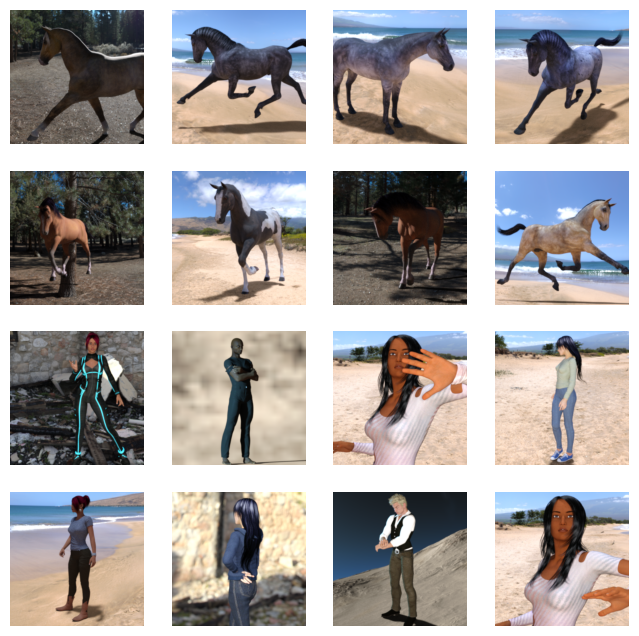

In [8]:
# 데이터 시각화
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 15  # 시작 인덱스

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*2, nrows*2)

pic_index += 8
next_horse_pix = [os.path.join(train_horse_dir, fname)
                for fname in train_horse_names[pic_index-8:pic_index]]
next_human_pix = [os.path.join(train_human_dir, fname)
                for fname in train_human_names[pic_index-8:pic_index]]

# print(next_horse_pix)
# print(next_human_pix)

for i, img_path in enumerate(next_horse_pix+next_human_pix):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

### CNN Model 구현

In [9]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 298, 298, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 149, 149, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 147, 147, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 73, 73, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 71, 71, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 35, 35, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 33, 33, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,606,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,704,097 (6.50 MB)

 Trainable params: 1,704,097 (6.50 MB)

 Non-trainable params: 0 (0.00 B)

### 데이터 전처리 : 이미지 증강(Image Augmentation)

In [10]:
# ! pip install Augmentor
# import Augmentor

# ## 증강 시킬 이미지 폴더 경로
# img = Augmentor.Pipeline("augmentation_test/")

# ## 좌우 반전
# img.flip_left_right(probability=1.0)

# ## 상하 반전
# img.flip_top_bottom(probability=1.0)

# ## 왜곡
# img.random_distortion(probability=1, grid_width=10, grid_height=10, magnitude=8)

# ## 증강 이미지 수
# img.sample(10)

In [11]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255.)

validation_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        '/tmp/horse-or-human/',  # This is the source directory for training images
        target_size=(300, 300),  # All images will be resized to 300x300
        batch_size=128,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')
        #save_to_dir='tmp/saved_train_image')

# Flow validation images in batches of 32 using validation_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        '/tmp/validation-horse-or-human/',  # This is the source directory for training images
        target_size=(300, 300),  # All images will be resized to 300x300
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')
        #save_to_dir='tmp/saved_val_image')  # 학습시 변환 생성된 이미지를 저장한다

print(train_generator)  # DirectoryIterator object , 실제 사용 시점(학습시)에 데이터 생성

# fit 호출시 1 epoch 마다 train 이미지 1027개 생성  : 15 epochs 일 경우 총 15*1027 증강 이미지 생성
# fit 호출시 1 epoch 마다 validation 이미지 256개 생성  : 15 epochs 일 경우 총 15*256 증강 이미지 생성

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


### 학습

In [12]:
import os

# NVIDIA가 아닌 GPU와 함께 사용시(GPU가 2개 이상일 경우) OOM 오류 발생

# OP_REQUIRES failed at pooling_ops_common.cc:455 : Resource exhausted: OOM when allocating tensor
# with shape[128,16,298,298] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc

# GPU를 아예 못 보게 하려면:
# os.environ["CUDA_VISIBLE_DEVICES"]=''      # 성공

# 두번째 실행시 반드시 shudown하여 초기화하고 다시 실행한다(Restart는 오류남)

# GPU 0만 보게 하려면:
#os.environ["CUDA_VISIBLE_DEVICES"]='0'    --> OOM오류발생

# GPU 1만 보게 하려면:
# os.environ["CUDA_VISIBLE_DEVICES"]='1'   --> OOM오류발생

# GPU 0과 1을 보게 하려면:
#os.environ["CUDA_VISIBLE_DEVICES"]='0,1'  --> OOM오류발생

# https://datamasters.co.kr/33


In [13]:
# CPU버전 : 약 8~9분 소요, GPU : 1.5분
history = model.fit(
      train_generator,      # x
      steps_per_epoch=8,    # 1027/128  , train image numbers/train batch_size
      epochs=15,
      verbose=1,
      validation_data = validation_generator,
      #validation_steps=8,   # 256/32  , validation image numbers/validation batch_size
)

Epoch 1/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 23s 694ms/step - accuracy: 0.4881 - loss: 0.7187 - val_accuracy: 0.5000 - val_loss: 0.7445
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.5078 - loss: 0.6929 - val_accuracy: 0.5000 - val_loss: 0.6889
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 374ms/step - accuracy: 0.5047 - loss: 0.7176 - val_accuracy: 0.5000 - val_loss: 0.6900
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.5859 - loss: 0.6432 - val_accuracy: 0.5000 - val_loss: 0.7904
Epoch 5/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 338ms/step - accuracy: 0.5888 - loss: 0.6487 - val_accuracy: 0.8594 - val_loss: 0.4525
Epoch 6/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.8281 - loss: 0.5180 - val_accuracy: 0.8320 - val_loss: 0.4333
Epoch 7/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 375ms/step - accuracy: 0.8119 - loss: 0.4657 - val_accuracy: 0.6992 - val_loss: 1.2482
Epoch 8/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.8984 - loss: 0.2663 - val_accuracy: 0.8789 - val_loss

### 학습 결과 시각화

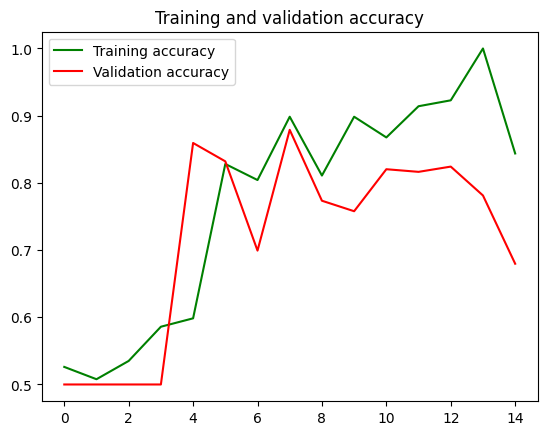

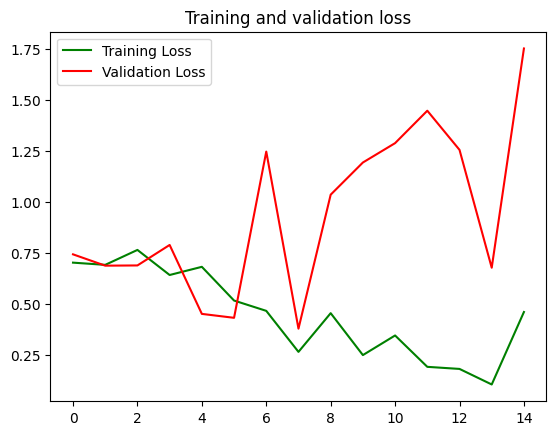

In [14]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 이미지 분류 예측

In [15]:
# import numpy as np
# from tensorflow.keras.preprocessing import image
# def image_predict(file_name):
#     path = 'horse-or-human예측용이미지/' + file_name
#     img = image.load_img(path, target_size=(300, 300))
#     x = image.img_to_array(img)   # 2차원 ndarray로 변환
#     x = np.expand_dims(x, axis=0) # 3차원으로 변환
#     images = np.vstack([x])       # 4차원으로 변환
#     classes = model.predict(images, batch_size=10)
#     # print(classes[0],end=' ')
#     if classes[0] == 1.0:
#         print(file_name ,': human')
#     else:
#         print(file_name ,': horse')

# image_predict('말01.jpg')
# image_predict('말02.jpg')
# image_predict('기린.jpg')
# image_predict('말과사람.jpg')
# image_predict('말과사람02.jpg')
# image_predict('말과사람06.jpg')
# image_predict('사람01.jpg')
# image_predict('사람02.jpg')
# image_predict('사람12.jpg')
# image_predict('말타기게임하는사람.jpg')

In [16]:
# ! dir/w "horse-or-human예측용이미지/"

In [17]:
class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            if (logs.get('accuracy') > 0.999):
                print("\nReached 99.9% accuracy so cancelling training!")
                self.model.stop_training = True

callbacks = myCallback()

In [18]:
train_datagen = ImageDataGenerator(rescale = 1./255.,
                               rotation_range = 40,
                               width_shift_range = 0.2,
                               height_shift_range = 0.2,
                               shear_range = 0.2,
                               zoom_range = 0.2,
                               horizontal_flip = True)

validation_datagen = ImageDataGenerator(rescale = 1.0/255.)

train_generator = train_datagen.flow_from_directory(train_dir,
                                        batch_size = 20,
                                        class_mode = 'binary',
                                        target_size = (300, 300))


validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                      batch_size  = 20,
                                      class_mode  = 'binary',
                                      target_size = (300, 300))

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [19]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

model.summary()

# CPU버전:약 15분 소요 ,epochs=10  , GPU: 약 4분
model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=50,  # 1027/20
    # epochs = 100,
    epochs=10,
    validation_steps=12,  # 256/20
    verbose=1,
    callbacks=[callbacks])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 298, 298, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 149, 149, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 147, 147, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 73, 73, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 71, 71, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 35, 35, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 78400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │      40,141,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,165,409 (153.22 MB)

 Trainable params: 40,165,409 (153.22 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 438ms/step - accuracy: 0.5524 - loss: 1.3303 - val_accuracy: 0.4958 - val_loss: 1.8027
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6715 - loss: 0.6163 - val_accuracy: 0.5625 - val_loss: 0.9136
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 413ms/step - accuracy: 0.7173 - loss: 0.5445 - val_accuracy: 0.5125 - val_loss: 2.4081
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - accuracy: 0.7775 - loss: 0.4518 - val_accuracy: 0.7500 - val_loss: 0.6074
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 410ms/step - accuracy: 0.8035 - loss: 0.4230 - val_accuracy: 0.5250 - val_loss: 2.9164
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - accuracy: 0.9010 - loss: 0.3475 - val_accuracy: 0.3750 - val_loss: 3.6198
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 418ms/step - accuracy: 0.8508 - loss: 0.3674 - val_accuracy: 0.5333 - val_loss: 4.0407
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - accuracy: 0.9490 - loss: 0.1812 - val_accuracy:

In [20]:
# epochs를 100으로 수정하여 학습 시켜 볼것